In [391]:
import pytreenet as ptn
import numpy as np
from pytreenet.operators import pauli_matrices
from pytreenet.operators import TensorProduct, Hamiltonian
from pytreenet import (
    TTNTimeEvolutionConfig,
    SecondOrderTwoSiteTDVP,
)
from pytreenet.util.tensor_splitting import SVDParameters
from pytreenet.operators import pauli_matrices
from typing import Dict
from pytreenet.operators import pauli_matrices
from numpy import ndarray, mean, zeros, kron, eye, asarray
from matplotlib.pyplot import subplots, show
from pytreenet import (
    TTNTimeEvolutionConfig,
    ExactTimeEvolution,
    TreeTensorNetworkOperator,
    TimeEvolution,
)

Create method for binary tree. Each node has one physical leg.

In [ ]:
def create_binary_tree(num_nodes):
    ttns = ptn.TreeTensorNetworkState()

    if num_nodes < 1:
        raise ValueError("The number of nodes must be at least 1.")

    zero_state = np.zeros((2,), dtype=complex)
    zero_state[0] = 1.0

    root_tensor = np.zeros((2, 2, 2), dtype=complex)
    root_tensor[:, :, 0] = zero_state.reshape(1, 1, 2)
    root_node = ptn.Node(identifier="site0")
    ttns.add_root(root_node, root_tensor)

    nodes = [("site0", root_node, root_tensor)]
    current_node_count = 1
    level_count = 0

    while current_node_count < num_nodes:
        parent_name = nodes.pop(0)[0]

        if current_node_count < num_nodes:
            left_name = f"site{current_node_count}"
            left_shape = (
                (2, 2) if (current_node_count * 2 + 1 >= num_nodes) else (2, 2, 2, 2)
            )
            left_tensor = np.zeros(left_shape, dtype=complex)
            left_tensor[..., 0] = zero_state
            left_child = ptn.Node(identifier=left_name)
            ttns.add_child_to_parent(left_child, left_tensor, 0, parent_name, 1)

            nodes.append((left_name, left_child, left_tensor))
            current_node_count += 1

        if current_node_count < num_nodes:
            right_name = f"site{current_node_count}"
            right_shape = (
                (2, 2) if (current_node_count * 2 + 1 >= num_nodes) else (2, 2, 2, 2)
            )
            right_tensor = np.zeros(right_shape, dtype=complex)
            right_tensor[..., 0] = zero_state
            right_child = ptn.Node(identifier=right_name)
            ttns.add_child_to_parent(right_child, right_tensor, 1, parent_name, 2)

            nodes.append((right_name, right_child, right_tensor))
            current_node_count += 1

        level_count += 1
    return ttns


binary_tree = create_binary_tree(9)

for ident, node in binary_tree.nodes.items():
    print(ident, node.children, node.open_legs)

site0 ['site1', 'site2'] [2]
site1 ['site3', 'site4'] [3]
site2 ['site5', 'site6'] [3]
site3 ['site7', 'site8'] [3]
site4 [] [1]
site5 [] [1]
site6 [] [1]
site7 [] [1]
site8 [] [1]


Heisenberg model hamiltonian with time evolution on the binary tree.

Each couple of nodes connected to each other will have three Heisenberg terms, one for each of the Pauli matrices.

In [393]:
factor = -1.0
time_step_size = 0.01
total_time = 1.0

In [ ]:
def generate_ham_heisenberg_model(binary_tree, factor):
    X, Y, Z = pauli_matrices()

    heisenberg_terms = []

    def add_heisenberg_term(node1, node2):
        heisenberg_terms.append(TensorProduct({node1: "-J*X", node2: "X"}))
        heisenberg_terms.append(TensorProduct({node1: "-J*Y", node2: "Y"}))
        heisenberg_terms.append(TensorProduct({node1: "-J*Z", node2: "Z"}))

    for ident, node in binary_tree.nodes.items():
        for child in node.children:
            add_heisenberg_term(ident, child)

    conversion_dict = {
        "-J*X": -1 * factor * X,
        "X": X,
        "-J*Y": -1 * factor * Y,
        "Y": Y,
        "-J*Z": -1 * factor * Z,
        "Z": Z,
        "I2": np.eye(2),
    }

    heisenberg_hamiltonian = Hamiltonian(heisenberg_terms, conversion_dict)
    return heisenberg_hamiltonian


def generate_heisenberg_model(binary_tree, factor):
    hamiltonian = generate_ham_heisenberg_model(binary_tree, factor)
    return TreeTensorNetworkOperator.from_hamiltonian(hamiltonian, binary_tree)


def generate_operators(binary_tree):
    """
    Generate the operators for the binary tree, including Z-Z interactions.
    """
    X, Y, Z = pauli_matrices()

    operators = {}
    for node_id, node_obj in binary_tree.nodes.items():
        if not node_obj.is_root():
            parent_id = node_obj.parent
            operators[f"ZZ_{parent_id}_{node_id}"] = TensorProduct(
                {node_id: Z, parent_id: Z}
            )

    return operators

In [404]:
svd = SVDParameters(max_bond_dim=10, rel_tol=1e-5, total_tol=0.0)
ttno = generate_heisenberg_model(binary_tree, factor)
operators = generate_operators(binary_tree)
config = TTNTimeEvolutionConfig(record_bond_dim=True)

tdvp_twosite = SecondOrderTwoSiteTDVP(
    binary_tree,
    ttno,
    time_step_size,
    total_time,
    operators,
    truncation_parameters=svd,
    config=config,
)

tdvp_twosite.run()

  0%|          | 0/101 [00:00<?, ?it/s]

100%|██████████| 101/101 [00:02<00:00, 37.95it/s]


The Exact Simulation

In [398]:
def generate_exact_heisenberg_hamiltonian(factor: float, num_sites: int) -> np.ndarray:
    """
    Generate the Heisenberg Hamiltonian.
    """

    ham = np.zeros((2**num_sites, 2**num_sites), dtype=complex)

    for i in range(num_sites - 1):
        term = asarray([1.0], dtype=complex)
        for j in range(num_sites):
            if j == i:
                term = kron(term, factor * pauli_matrices()[0])
            elif j == i + 1:
                term = kron(term, pauli_matrices()[0])
            else:
                term = kron(term, eye(2))
        ham += term

    for i in range(num_sites - 1):
        term = asarray([1.0], dtype=complex)
        for j in range(num_sites):
            if j == i:
                term = kron(term, factor * pauli_matrices()[1])
            elif j == i + 1:
                term = kron(term, pauli_matrices()[1])
            else:
                term = kron(term, eye(2))
        ham += term

    for i in range(num_sites - 1):
        term = asarray([1.0], dtype=complex)
        for j in range(num_sites):
            if j == i:
                term = kron(term, factor * pauli_matrices()[2])
            elif j == i + 1:
                term = kron(term, pauli_matrices()[2])
            else:
                term = kron(term, eye(2))
        ham += term

    return ham


def generate_exact_initial_state(num_sites: int, local_dim: int) -> ndarray:
    """
    Generate the exact all zero initial state for an Ising model.
    """
    state = zeros(local_dim**num_sites, dtype=complex)
    state[0] = 1.0
    return state


def generate_exact_operators(num_sites: int) -> Dict[str,ndarray]:
    """
    Generate the exact single site operators for all sites.
    """
    operators = {}
    for i in range(num_sites):
        operator = asarray([1.0], dtype=complex)
        for j in range(num_sites):
            if j == i:
                operator = kron(operator,pauli_matrices()[2])
            else:
                operator = kron(operator,eye(2))
        operators["site"+str(i)] = operator
    return operators

In [399]:
time_step_size = 0.01
num_sites = 9
final_time = 1.0
local_dim = 2
factor = -2.0
intial_state_exact = generate_exact_initial_state(num_sites, local_dim)
ham_exact = generate_exact_heisenberg_hamiltonian(factor, num_sites)
operators_exact = generate_exact_operators(num_sites)
exact_evo = ExactTimeEvolution(
    intial_state_exact, ham_exact, time_step_size, final_time, operators_exact
)

exact_evo.run()

100%|██████████| 101/101 [00:00<00:00, 386.31it/s]


Calculate Magnetization

In [400]:
def compute_total_magn(evo: TimeEvolution) -> ndarray:
    """
    Compute the total magnetization of the system.
    """
    local_magn = evo.operator_results(realise=False)[:-1]
    magn = mean(local_magn, axis=0)
    return magn


magn_exact = compute_total_magn(exact_evo)
magn_tdvp = compute_total_magn(tdvp_twosite)

Plot

C:\Users\Admin\AppData\Roaming\Python\Python312\site-packages\matplotlib\cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
C:\Users\Admin\AppData\Roaming\Python\Python312\site-packages\matplotlib\cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


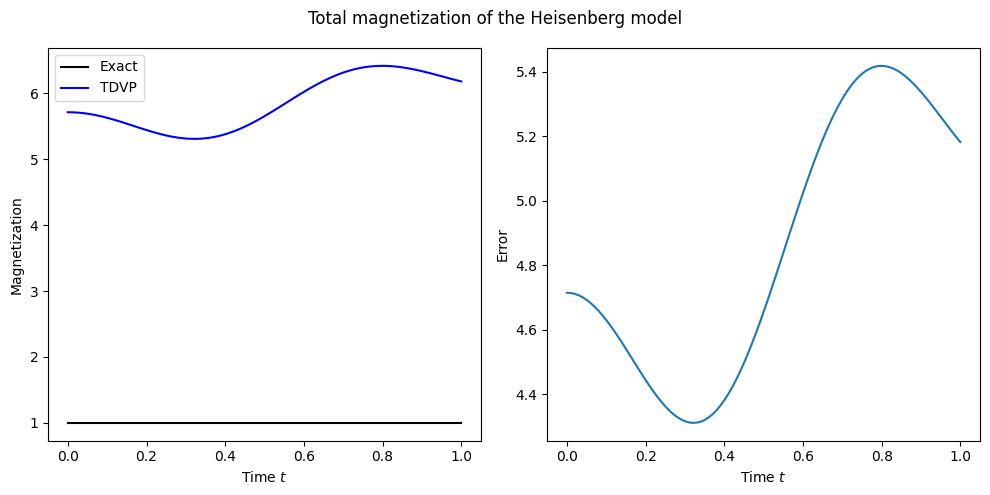

In [401]:

figure, axs = subplots(1, 2, figsize=(10, 5))
times = exact_evo.times()

axs[0].plot(times, magn_exact, label="Exact", color="black")
axs[0].plot(times, magn_tdvp, label="TDVP", color="blue")
axs[0].set_xlabel("Time $t$")
axs[0].set_ylabel("Magnetization")
axs[0].legend()

axs[1].plot(times, abs(magn_exact - magn_tdvp))
axs[1].set_xlabel("Time $t$")
axs[1].set_ylabel("Error")

figure.suptitle("Total magnetization of the Heisenberg model")
figure.tight_layout()
show()